<a href="https://colab.research.google.com/github/sccn/sound2meg/blob/main/wav2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install --upgrade pip
!pip install wheel setuptools
!pip install fairseq


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fairseq-0.12.2.tar.gz (9.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached omegaconf-2.0.6-py3-none-any.whl (36 kB)
  Using cached bitarray-2.7.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (269 kB)
  Using cached sacrebleu-2.3.1-py3-none-any.whl (118 kB)
  Using cached hydra_core-1.0.7-py3-none-any.whl

In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import re
import numpy as np
import torch
import torch.nn.functional as F
import os
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2FeatureExtractor
import librosa
import fairseq
import torch
from torch import nn
import pandas as pd
import wave
import librosa
from resampy import resample
import gc

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
def segment_audio(audio_file):
    audio_input, sample_rate = librosa.load(audio_file)
    audio_segment = sample_rate * 3
    segments = []
    if len(audio_input) >= audio_segment * 2:
      check = True
      while check:
          segments.append(audio_input[:audio_segment])
          audio_input = audio_input[audio_segment:]
          if len(audio_input) < audio_segment:
              check = False
    else:
      segments.append(audio_input[:audio_segment])
    return segments, sample_rate

# return first 3 second segment in audio file
def three_second(audio_file):
    audio_input, sample_rate = librosa.load(audio_file, mono = True, sr = None)
    audio_segment = sample_rate * 3
    segment = audio_input[:audio_segment]
    data = resample(segment, sample_rate, 16000)
    return data, sample_rate


def read_event(tsv_path):
    event = pd.read_csv("sub-A2014_task-auditory_events.tsv", sep = '\t')
    event = event[event['type'] == 'Sound']

    batch["onset"], batch["sample"], batch["audio_file"] = event['onset'], event['sample'], event['audio_file']
    
    return batch


def prepare_dataset(batch, feature_extractor):
    for audio in audio_file_directory:
        if audio in batch["audio_file"]:
            segment, sample_rate = three_second(audio)
            #segment, sample_rate = segment_audio(audio)
            
            feature_extractor = prepare_feature_extractor(sample_rate)
            batch["input_values"] = feature_extractor(segment, return_tensors="pt").input_values

    return batch

def prepare_model(model_config = None):
    model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53",
    config = model_config
)
    model.freeze_feature_extractor()
    return model

def prepare_feature_extractor(sampling_rate):
    # check that all files have the correct sampling rate
    #feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=sampling_rate, padding_value=0.0, do_normalize=True, return_attention_mask=True)
    feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, 
                                                 sampling_rate=16000, 
                                                 padding = False,
                                                 padding_value=0.0, 
                                                 do_normalize=True, 
                                                 return_attention_mask=True)
    return feature_extractor


def check_wav_hz(filepath):
    with wave.open(filepath, 'r') as wav_file:
        # Get the sample rate (in Hz)
        sample_rate = wav_file.getframerate()
        return sample_rate

In [3]:
class wav_model(nn.Module):
  def __init__(self, wav2vec_model):
    super(wav_model, self).__init__()
    self.activation_lst = []
    self.extract_layer = wav2vec_model.wav2vec2.feature_extractor
    self.projection_layer = wav2vec_model.wav2vec2.feature_projection
    self.encoding_layer = wav2vec_model.wav2vec2.encoder.pos_conv_embed
    self.layer_norm = wav2vec_model.wav2vec2.encoder.layer_norm
    self.dropout = wav2vec_model.wav2vec2.encoder.dropout
    self.transfomer = wav2vec_model.wav2vec2.encoder.layers

    self.attention = self.transfomer[0].attention
    self.feed_forward = self.transfomer[0].feed_forward
    # self.intermediate_dropout = self.transfomer[0].feed_forward.intermediate_dropout
    # self.intermediate_dense = self.transfomer[0].feed_forward.intermediate_dense
    # self.intermediate_act_fn = self.transfomer[0].feed_forward.intermediate_act_fn
    # self.output_dense = self.transfomer[0].feed_forward.output_dense
    # self.output_dropout = self.transfomer[0].feed_forward.output_dropout

    self.final_layer_norm = self.transfomer[0].final_layer_norm

    # self.final_dropout = wav2vec_model.dropout
    # self.fc = wav2vec_model.lm_head

    # self.trasfomer_layer_post = nn.Sequential(self.output_dense,
    #                                          self.output_dropout,
    #                                          self.layer_norm)
    
  def forward(self, x):
    x = self.extract_layer(x)
    x = self.projection_layer(x.transpose(1, 2))
    x = self.encoding_layer(x[0])
    x = self.layer_norm(x)
    x = self.dropout(x)
    
    for i in range(len(self.transfomer)):
      if i < 20:
        if type(x) == tuple:
          x = x[0]
        x = self.transfomer[i](x)
      else:
        if type(x) == tuple:
          x = x[0]
        activation = self.transfomer[i](x)
        self.activation_lst.append(activation[0])

    sum_activation = torch.sum(torch.stack(self.activation_lst), dim=0)

    average_activation = torch.div(sum_activation, 4)

    del x, sum_activation, activation
    return average_activation

In [4]:
audio_path = "/content/drive/MyDrive/Sound_files"
files = os.listdir(audio_path)

embedding_path = "/content/drive/MyDrive/Embedding"
embedding_files = os.listdir(embedding_path)

wav2vec = prepare_model()
model = wav_model(wav2vec)

# for wav_file in files:
#     count = 0
#     name = re.search('(\d+)\.', wav_file).group().replace('.', '_')

#     audio = os.path.join(audio_path, wav_file)

#     audio_input, sample_rate = segment_audio(audio)
#     feature_extractor = prepare_feature_extractor(sample_rate)

#     if len(audio_input) > 1:
#         for audio in audio_input:
#             input_values = feature_extractor(audio, return_tensors="pt").input_values
#             logits = model(input_values).logits

#             output = logits.detach().numpy()
#             np.save(f'{name}{count}.npy', output)

#             count += 1
#     else:
#         input_values = feature_extractor(audio_input, return_tensors="pt").input_values
#         logits = model(input_values).logits

#         output = logits.detach().numpy()
#         np.save(f'{name}.npy', output)

# Only first three second segements
for wav_file in files:
    name = re.search('(\d+)\.', wav_file).group().replace('.', '')

    if f'{name}.npy' in embedding_files:
      continue
    else:
      audio_len = 48000
      audio = os.path.join(audio_path, wav_file)
      audio_input, sample_rate = three_second(audio)

      if len(audio_input) < audio_len:
        padding = np.zeros(audio_len - len(audio_input))
        audio_input = np.concatenate((audio_input, padding))
      #audio_input, sample_rate = librosa.load(audio)
      feature_extractor = prepare_feature_extractor(sample_rate)

      input_values = feature_extractor(audio_input, return_tensors="pt", sampling_rate = 16000).input_values
      hidden_states = model(input_values)
      hidden_states = torch.transpose(hidden_states, 1, 2)
      output = F.interpolate(hidden_states, size=360)
      print(output.shape)
      output = output.detach().numpy()
      np.save(os.path.join('/content/drive/MyDrive/Embedding', f'{name}.npy'), output)

      del audio_input, feature_extractor, input_values, hidden_states, output
        # del padding
        # del feature_extractor
        # del input_values
        # del hidden_states
        # del output
        # gc.collect()


Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2ForCTC: ['quantizer.weight_proj.bias', 'quantizer.weight_proj.weight', 'project_hid.bias', 'project_hid.weight', 'project_q.weight', 'project_q.bias', 'quantizer.codevectors']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to u

torch.Size([1, 1024, 360])
torch.Size([1, 1024, 360])
torch.Size([1, 1024, 360])
torch.Size([1, 1024, 360])


In [10]:
audio_path = "/content/drive/MyDrive/Sound_files"
files = os.listdir(audio_path)

model = prepare_model()

# Only first three second segements
for wav_file in files:
    # name = re.search('(\d+)\.', wav_file).group().replace('.', '')

    # np_file = np.load(os.path.join('/content/drive/MyDrive/Embedding', f'{name}.npy'))

    # if np_file.shape == (1, 360, 1024):
    #   continue
    # else:
    audio = os.path.join(audio_path, wav_file)
    audio_input, sample_rate = three_second(audio)

    #audio_input, sample_rate = librosa.load(audio)
    feature_extractor = prepare_feature_extractor(sample_rate)

    input_values = feature_extractor(audio_input, return_tensors="pt", sampling_rate = 16000).input_values
    output = model(input_values).logits   
    
    output = output.detach().numpy()
    print(output.shape)
    np.save(os.path.join('/content/drive/MyDrive/Embedding', f'{name}.npy'), output)
      # del padding
      # del feature_extractor
      # del input_values
      # del hidden_states
      # del output
      # gc.collect()

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2ForCTC: ['project_hid.bias', 'quantizer.weight_proj.bias', 'project_q.bias', 'project_q.weight', 'quantizer.codevectors', 'project_hid.weight', 'quantizer.weight_proj.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to u

(1, 149, 32)
(1, 149, 32)
(1, 149, 32)


KeyboardInterrupt: ignored

In [5]:
import os
import numpy as np
folder_path = '/content/drive/MyDrive/Embedding'

# List all the files in the folder
files = os.listdir(folder_path)

# Delete each file in the folder
for file_name in files:
  if file_name.split('.')[0].isdigit():
    file_path = os.path.join(folder_path, file_name)
    np_file = np.load(file_path)
    print(np_file.shape)


(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)
(1, 1024, 360)


In [12]:

folder_path = '/content/drive/MyDrive/Embedding'

# List all the files in the folder
files = os.listdir(folder_path)

# Delete each file in the folder
for file_name in files:
  try:
      file_path = os.path.join(folder_path, file_name)
      os.remove(file_path)
  except:
    continue

In [1]:
import os
folder_path = '/content/drive/MyDrive/Embedding'

# List all the files in the folder
files = os.listdir(folder_path)
len(files)

697

In [7]:
import re
import os
import numpy as np

audio_path = "/content/drive/MyDrive/Sound_files"
files = os.listdir(audio_path)
count = 0


for wav_file in files:
    name = re.search('(\d+)\.', wav_file).group().replace('.', '')

    np_file = np.load(os.path.join('/content/drive/MyDrive/Embedding', f'{name}.npy'))
    print(np_file.shape)
    if np_file.shape == (1, 1024, 360):
      count += 1
print(count)

(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 1024, 149)
(1, 360, 1024)
(1, 360, 1024)
(1, 360, 1024)
(1, 360, 1024)
(1, 360, 1024)
(1, 360, 1024)
(1, 360, 1024)
(1, 360, 1024)
(1, 360, 1024)
(1, 360, 1024)
(1, 360, 1024)
(1, 360, 1

In [ ]:
wav2vec = prepare_model()
model_config = wav2vec.config
model_config.output_hidden_states=True
# model_config.conv_stride = [4, 3, 3, 2, 2, 1, 1]   #[1, 1, 1, 3, 3, 3, 5] = 356
wav2vec = prepare_model(model_config)

In [ ]:
wav, sample_rate  = three_second('EQ_Ramp_Int2_Int1LPF001.wav')

In [ ]:
feature_extractor = prepare_feature_extractor(sample_rate)
input_values = feature_extractor(wav, return_tensors="pt", sampling_rate = 16000).input_values

hidden_states = wav2vec(input_values).hidden_states
print(hidden_states[0].shape)

torch.Size([1, 149, 1024])


In [ ]:
print(hidden_states[1].shape)

torch.Size([1, 149, 1024])


In [ ]:
padding = np.zeros(48600 - len(wav))
wav = np.concatenate((wav, padding))

feature_extractor = prepare_feature_extractor(sample_rate)
input_values = feature_extractor(wav, return_tensors="pt").input_values

logits = wav2vec(input_values).logits
print(logits.shape)

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


torch.Size([1, 360, 32])


In [ ]:
logits[0][:360, :].shape

torch.Size([360, 32])

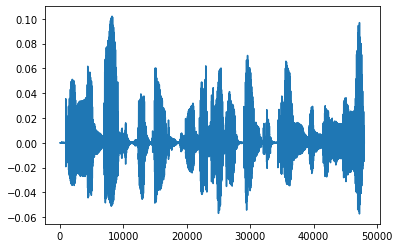

In [ ]:
plt.plot(audio_resampled)

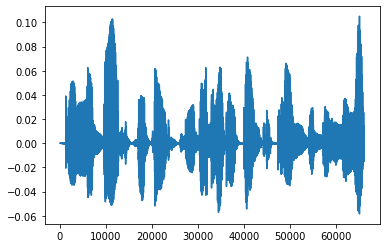

In [ ]:
plt.plot(audio_input)

In [ ]:
from scipy.interpolate import interp1d  

dt = 16000 * 3
Told = np.linspace(audio_input.min(),audio_input.max(),len(audio_input))
print(audio_input.shape)
print(Told.shape)
F = interp1d(Told,audio_input,fill_value='extrapolate') 
Tnew = np.linspace(audio_input.min(), audio_input.max(), dt)
audio_resampled = F(Tnew)

(66150,)
(66150,)


In [ ]:
audio_resampled.shape

(48000,)

In [ ]:
audio, sr = librosa.load("/content/audio/EQ_Ramp_Int2_Int1LPF001.wav", mono = True, sr = 16000)
print(audio.shape)

(78820,)


In [ ]:
sr

44100

In [ ]:
path = '/content/drive/MyDrive/Embedding'

lst =  os.listdir(path)

for file in lst:
  audio_pth = os.path.join(path, file)

  if file.split('.')[0].isdigit():
    audio = np.load(audio_pth, allow_pickle=True)
    if audio.shape[0] != 360:
      print("file name: " + file + ", shape: " + str(audio.shape))

file name: 268.npy, shape: (358, 32)
file name: 325.npy, shape: (357, 32)


In [ ]:
audio = np.load('/content/drive/MyDrive/Embedding/226.npy', allow_pickle=True)
audio.shape

(360, 32)